# Reproducibility challenge (notebook 2)
### Fundamentals of Inference and Learning, EE-411
#### Thomas Lenges, Renuka Singh Virk


In this notebook, we attempt to reproduce Figure 4 from the paper "Reconciling modern machine learning practice and the bias-variance trade-of" by $\textit{Mikhail Belkin}$, $\textit{Daniel Hsu}$, $\textit{Siyuan Ma}$, $\textit{Soumik Mandal}$.

## Double descent risk curve for fully connected neural network model on MNIST.

n = nb. samples

N = nb. features

K = nb. classes

H = nb. hidden units

n*K = interpolation threshold

**Conditions for reproducibility:**

* **Data:**
    * n = 4 * 10^3 samples (subsample without replacement)
    * K = 10, nb. classes
    * One-hot encoding
    * Number of Parameters = (d+1) * H + (H+1) * K
    * Normalize data
* **Model:**
    * d = 784 (input dimensions = nb. pixels 28x28)
    * Squared loss function
    * No regularization
    * 5-fold repetition and average results (ideally, not done in our case (too computationally costly)
    * Single hidden layer
    * SGD optimizer with standard momentum (0.95)
    * **Weight Reuse:**
        * For under-parametrized models (N < K * n) <==> (H < 50):
            * Initialize hidden units of the larger network with weights learned in the smaller network.
            * Initialize remaining weights with normal distribution (mean 0, variance 0.01).
            * Smallest network initialized with Glorot uniform distribution.
        * For over-parametrized models (N >= K * n) <==> (H > 50):
            * Random initialization.
    * **Learning Rate:**
        * If smaller than interpolation threshold (n*K): Decay learning rate by 10% after 500 epochs.
        * If bigger than interpolation threshold: Fixed learning rate.
    * **Stopping Criteria:**
        * Stop training after 2000

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


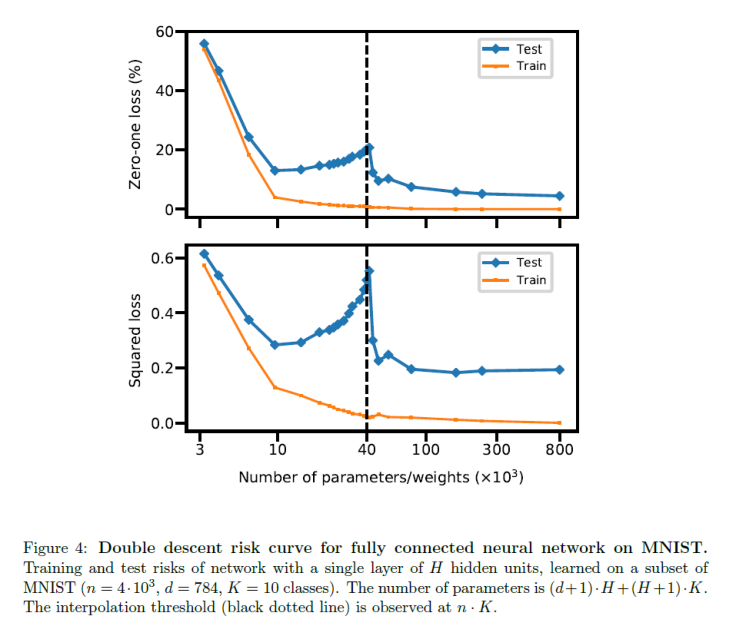

In [ ]:
# Paper figure to be reproduced
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = './Figure4_paper.png'

img = mpimg.imread(image_path)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [1]:
# Imports
from torchvision import datasets, transforms
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Hyperparameters
num_training_data = 4000 # Subsample size
num_test_data = 10000    # Use the full MNIST test set
K = 10
d = 784

In [3]:
# Data Preprocessing
def preprocess_mnist(num_training_data, num_test_data, num_classes):

  # Transformations
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.3081,)),  # Normalize data with mean and standard deviation of the MNIST dataset
      transforms.Lambda(lambda x: x.view(-1))      # Flatten the image (28x28)
  ])

  # Load MNIST datasets
  mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
  mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  # Subsample training data
  indices = np.random.choice(len(mnist_train), num_training_data, replace=False)
  train_subset = torch.utils.data.Subset(mnist_train, indices)

  # Create data loaders (without shuffling)
  train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=False)
  test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False)

  return train_loader, test_loader

train_loader, test_loader = preprocess_mnist(num_training_data, num_test_data, K)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 347kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.22MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.15MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Model definition
class FullyConnectedNN(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units)
        self.fc2 = nn.Linear(hidden_units, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
# Weight initialization
def initialize_weights(network, hidden_units, prev_weights=None):
    if (prev_weights is None) and (hidden_units < 50):  # Glorot uniform for the smallest network
        print(f"Initializing weights with Glorot uniform for hidden_units = {hidden_units}")
        nn.init.xavier_uniform_(network.fc1.weight) # Weight Initialization
        nn.init.zeros_(network.fc1.bias) # Bias Initialization
        nn.init.xavier_uniform_(network.fc2.weight)
        nn.init.zeros_(network.fc2.bias)
    elif hidden_units < 50:  # Reuse weights from the previous smaller network (when N < K * n) <==> (H < 50)
        print(f"Reusing previous weights and initializing additional weights with normal distribution for hidden_units = {hidden_units}")

        # Reuse previous weights for the smaller dimensions
        prev_fc1_size = prev_weights['fc1'].size(0)
        prev_fc2_size = prev_weights['fc2'].size(0)
        target_fc1_size = network.fc1.weight.data.size(0)
        target_fc2_size = network.fc2.weight.data.size(0)

        # Match dimensions for fc1
        min_fc1_input = min(prev_weights['fc1'].size(1), network.fc1.weight.data.size(1))
        network.fc1.weight.data[:prev_fc1_size, :min_fc1_input] = prev_weights['fc1'][:prev_fc1_size, :min_fc1_input]

        # Handle additional weights for fc1
        if prev_fc1_size < target_fc1_size or prev_weights['fc1'].size(1) < network.fc1.weight.data.size(1):
            nn.init.normal_(network.fc1.weight.data[prev_fc1_size:], mean=0, std=np.sqrt(0.01))

        # Match dimensions for fc2
        min_fc2_input = min(prev_weights['fc2'].size(1), network.fc2.weight.data.size(1))
        network.fc2.weight.data[:prev_fc2_size, :min_fc2_input] = prev_weights['fc2'][:prev_fc2_size, :min_fc2_input]

        # Handle additional weights for fc2
        if prev_fc2_size < target_fc2_size or prev_weights['fc2'].size(1) < network.fc2.weight.data.size(1):
            nn.init.normal_(network.fc2.weight.data[prev_fc2_size:], mean=0, std=np.sqrt(0.01))
    else:  # H >= 50, initialize all weights with a normal distribution
        print(f"Initializing all weights with normal distribution for hidden_units = {hidden_units}")
        nn.init.normal_(network.fc1.weight, mean=0, std=np.sqrt(0.01))
        nn.init.zeros_(network.fc1.bias)
        nn.init.normal_(network.fc2.weight, mean=0, std=np.sqrt(0.01))
        nn.init.zeros_(network.fc2.bias)

In [6]:
# Training and evaluation
def train_and_evaluate(hidden_units, train_loader, test_loader, prev_weights):
    model = FullyConnectedNN(784, hidden_units, 10)
    initialize_weights(model, hidden_units, prev_weights)

    optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.95)
    criterion = nn.MSELoss()

    # Learning rate scheduler: Decay learning rate by 10% every 500 epochs for H < 50
    if hidden_units < 50:
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)
    else:
        scheduler = None  # Fixed learning rate for H >= 50

    # Training loop
    for epoch in range(2000):
        model.train()
        total_loss = 0  # Accumulate training error
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)

            # Train losses
            train_squared_loss = criterion(output, torch.nn.functional.one_hot(target, num_classes=10).float()).item()
            train_zero_one_loss = (torch.argmax(output, dim=1) != target).float().mean().item()

            loss = criterion(output, torch.nn.functional.one_hot(target, num_classes=10).float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()


        # Print the learning rate before each optimizer step
        current_lr = optimizer.param_groups[0]['lr']
        # print(f"Current Learning Rate: {current_lr:.6f}")

        # Step the learning rate scheduler
        if scheduler:
            scheduler.step()


    # Evaluation
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_zero_one_loss = (torch.argmax(output, dim=1) != target).float().mean().item()
            test_squared_loss = torch.mean((output - torch.nn.functional.one_hot(target, num_classes=10).float()) ** 2).item()

    # Update prev_weights to pass to the next iteration
    prev_weights = {
        'fc1': model.fc1.weight.data.clone(),
        'fc2': model.fc2.weight.data.clone(),
    }

    return prev_weights, train_zero_one_loss, train_squared_loss, test_zero_one_loss, test_squared_loss

In [7]:
# Compute H values
def calculate_h_values(target_parameters):
  """
  Calculates the values of H that satisfy the equation:
  (784 + 1) * H + (H + 1) * 10 = target_parameters
  """
  h_list = []
  for target_parameter in target_parameters:
    h = (target_parameter - 10) / 795
    h_list.append(int(np.ceil(h)))

  return h_list

# Example usage:
target_values = [40000, 45000, 100000] # [3000, 8000, 10000, 20000, 35000] (cut in different parts to avoid colab crashes)
h_values = calculate_h_values(target_values)
print(h_values)

[51, 57, 126]


In [8]:
# Experiment: Vary H and collect result
# what we wanted to test: H = [5, 7, 10, 15, 20, 25, 29, 33, 37, 40, 42, 44, 46, 48, 50, 52, 54, 60, 70, 280, 480, 880]
results = []
num_runs = 1  # Number of repetitions
prev_weights = None  # To store weights of the previous network


# Initialize accumulators for the results across all runs
aggregated_results = {h: {'train_zero_one_losses': [],
                          'train_squared_losses': [],
                          'test_zero_one_losses': [],
                          'test_squared_losses': []} for h in h_values}

for run in range(num_runs):
    print(f"Starting run {run + 1}/{num_runs}")

    for hidden_units in h_values:
        print(f"Training with {hidden_units} hidden units (Run {run + 1})")

        # Train and evaluate the model for this hidden_units value
        prev_weights, train_zero_one_loss, train_squared_loss, test_zero_one_loss, test_squared_loss = train_and_evaluate(
            hidden_units, train_loader, test_loader, prev_weights
        )

        # Store the results for this hidden_units level
        aggregated_results[hidden_units]['train_zero_one_losses'].append(train_zero_one_loss)
        aggregated_results[hidden_units]['train_squared_losses'].append(train_squared_loss)
        aggregated_results[hidden_units]['test_zero_one_losses'].append(test_zero_one_loss)
        aggregated_results[hidden_units]['test_squared_losses'].append(test_squared_loss)

    prev_weights = None # In case multiple runs

# Compute the mean results across all runs for each hidden_units value
for hidden_units in h_values:
    results.append((
        hidden_units,
        np.mean(aggregated_results[hidden_units]['train_zero_one_losses']),
        np.mean(aggregated_results[hidden_units]['train_squared_losses']),
        np.mean(aggregated_results[hidden_units]['test_zero_one_losses']),
        np.mean(aggregated_results[hidden_units]['test_squared_losses']),
    ))


Starting run 1/1
Training with 51 hidden units (Run 1)
Initializing all weights with normal distribution for hidden_units = 51
Training with 57 hidden units (Run 1)
Initializing all weights with normal distribution for hidden_units = 57
Training with 126 hidden units (Run 1)
Initializing all weights with normal distribution for hidden_units = 126


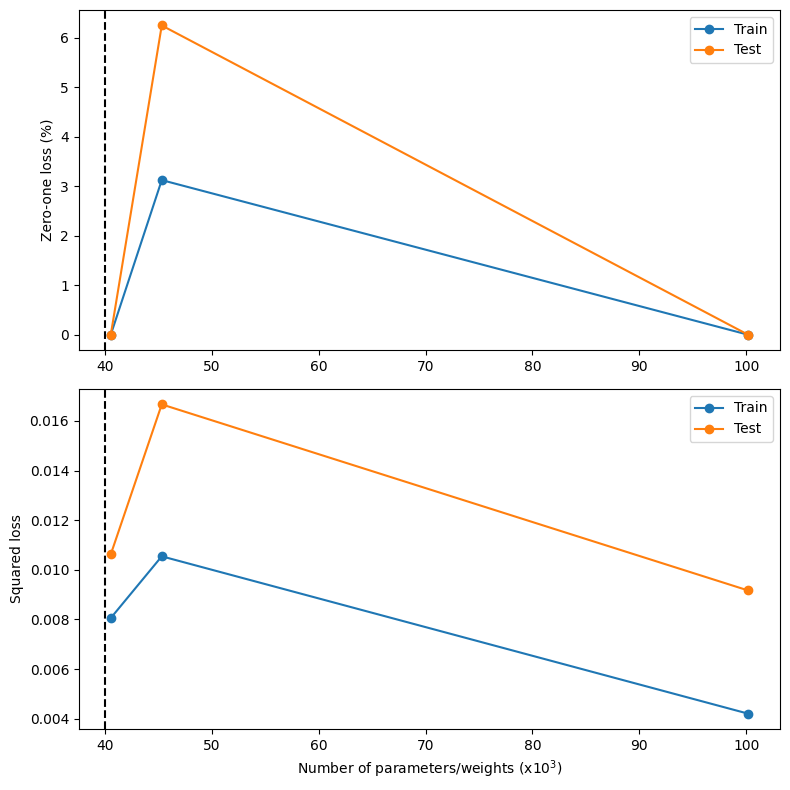

In [9]:
# Plot results
hidden_units, train_zero_one_loss, train_squared_loss, test_zero_one_loss, test_squared_loss = zip(*results)
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

H = hidden_units

x_axis = [((d + 1) * h + (h + 1) * K) / 1000 for h in H]
# Calculate the line position for K * num_training_data
line_position = (K * num_training_data) / 1000

# Subplot 1: Zero-One Loss
axes[0].plot(x_axis, np.array(train_zero_one_loss) * 100, label='Train', marker='o')
axes[0].plot(x_axis, np.array(test_zero_one_loss) * 100, label='Test', marker='o')
axes[0].axvline(line_position, color='black', linestyle='--')
axes[0].set_ylabel('Zero-one loss (%)')
axes[0].legend()

# Subplot 2: Squared Loss
axes[1].plot(x_axis, train_squared_loss, label='Train', marker='o')
axes[1].plot(x_axis, test_squared_loss, label='Test', marker='o')
axes[1].axvline(line_position, color='black', linestyle='--')
axes[1].set_xlabel('Number of parameters/weights (x$10^3$)')
axes[1].set_ylabel('Squared loss')
axes[1].legend()

plt.tight_layout()

fig.savefig('Figure4.png', dpi=300, bbox_inches='tight')

plt.show()


In [10]:
# Necessary as we needed to cut runs in smaller groups to avoid colab crashes
import pandas as pd
import numpy as np

results_df = pd.DataFrame({
    'Hidden Units': H,
    'Parameters (x10^3)': x_axis,
    'Train Zero-One Loss (%)': (np.array(train_zero_one_loss) * 100).tolist(),
    'Test Zero-One Loss (%)': (np.array(test_zero_one_loss) * 100).tolist(),
    'Train Squared Loss': train_squared_loss,
    'Test Squared Loss': test_squared_loss
})

# Save to CSV
results_df.to_csv('results.csv', index=False)
